**Assignment 1 - Khanh Nguyen**
===========================

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np

In [2]:
df_master_song_list = pd.read_json('MasterSongList.json')
df_master_song_list.head()

,_id,album,artist,audio_features,context,decades,genres,lyrics_features,moods,name,new_context,picture,recording_id,sub_context,yt_id,yt_views
0,{u'$oid': u'52fdfb440b9398049f3d7a8c'},Gangnam Style (강남스타일),PSY,"[11, 0.912744, 0.083704, 132.069, 0.293137, 0....",[work out],[],[pop],"[oppa, gangnam, style, gangnam, style, najeneu...","[energetic, motivational]",Gangnam Style (강남스타일),work out,http://images.musicnet.com/albums/073/463/405/...,50232.0,[working out: cardio],9bZkp7q19f0,2450112089
1,{u'$oid': u'52fdfb3d0b9398049f3cbc8e'},Native,OneRepublic,"[6, 0.745704, 0.119955, 100.008, 0.046255, 0.0...",[energetic],[2012],[pop],"[lately, i, ve, been, i, ve, been, losing, sle...",[happy],Counting Stars,energetic,http://images.musicnet.com/albums/081/851/887/...,5839.0,[energy boost],hT_nvWreIhg,1020297206
2,{u'$oid': u'52fdfb420b9398049f3d3ea5'},Party Rock Anthem,LMFAO,"[5, 0.709932, 0.231455, 130.03, 0.121741, 0.03...","[energetic, energetic, energetic, energetic]",[],[],"[party, rock, yeah, woo, let, s, go, party, ro...","[happy, celebratory, rowdy]",Party Rock Anthem,housework,http://images.musicnet.com/albums/049/414/127/...,52379.0,"[energy boost, pleasing a crowd, housework, dr...",KQ6zr6kCPj8,971128436
3,{u'$oid': u'52fdfb410b9398049f3d1eac'},Gentleman,PSY,"[3, 0.705822, 0.053292, 126.009, 0.126016, 0.0...","[party, party, party, party, party, party]",[2010s],[dance],"[alagamun, lan, weh, wakun, heya, hanun, gon, ...","[happy, energetic, celebratory]",Gentleman,energetic,http://images.musicnet.com/albums/082/950/461/...,12353.0,"[driving in the left lane, energy boost, girls...",ASO_zypdnsQ,892096527
4,{u'$oid': u'52fdfb400b9398049f3d0b19'},On The Floor,Jennifer Lopez,"[3, 0.741757, 0.072774, 129.985, 0.051255, 0.0...","[party, party]",[2000s],[reggaeton],"[j, lo, the, other, side, out, my, mine, it, s...",[energetic],On The Floor,work out,http://images.musicnet.com/albums/050/131/765/...,29502.0,"[working out: cardio, dance party: sweaty]",t4H_Zoh7G5A,873285189


In [3]:
df_master_song_list['genres'] = df_master_song_list['genres'].apply(' '.join)
df_master_song_list['genres'] = df_master_song_list['genres'].map(lambda x: x.split(':')[0] if len(x) > 0 else x)
# df_master_song_list.head()

In [4]:
def filter_genres(df, arg):
    if len(arg) <= 0:
        return df.copy()
    filtered_result = pd.Series(np.zeros(df.shape[0], dtype=bool))
    for genre in arg:
        filtered = df['genres'] == genre
        filtered_result |= filtered
    return df[filtered_result].copy()
df_master_song_filtered = filter_genres(df_master_song_list, ['rap', 'jazz'])
df_master_song_filtered.groupby('genres').count()

,_id,album,artist,audio_features,context,decades,lyrics_features,moods,name,new_context,picture,recording_id,sub_context,yt_id,yt_views
genres,,,,,,,,,,,,,,,
jazz,2295,2295,2295,2295,2295,2295,2295,2295,2295,2123,2295,1753,2123,2295,2295
rap,2931,2931,2931,2931,2931,2931,2931,2931,2931,2535,2931,2603,2535,2931,2931


In [5]:
# Remove nan row
null_audio_features = df_master_song_filtered[df_master_song_filtered.audio_features.str.len() == 0]
df_master_song_filtered.drop(null_audio_features.index, inplace=True)

In [6]:
def balance_classes(df, column):
    classes = df[column].unique()
    count_classes = df[column].value_counts()
    min_class = count_classes.idxmin()
    for _class in count_classes.index.values:
        if _class == min_class:
            continue
        num_of_drop_rows = count_classes[_class] - count_classes[min_class]
        selected_remove_row = df[df[column] == _class].sample(n=num_of_drop_rows)
        df.drop(selected_remove_row.index, axis=0, inplace=True)
    return df

df_master_song_filtered_bal = balance_classes(df_master_song_filtered, 'genres')
df_master_song_filtered_bal.reset_index(inplace=True, drop=True)
df_master_song_filtered_bal['genres'].value_counts()

rap     1890
jazz    1890
Name: genres, dtype: int64

In [7]:
feature_col_names = [
                        'key',
                        'energy',
                        'liveliness',
                        'tempo',
                        'speechiness',
                        'acousticness',
                        'instrumentalness',
                        'time_signature',
                        'duration',
                        'loudness',
                        'valence',
                        'danceability',
                        'mode',
                        'time_signature_confidence',
                        'tempo_confidence',
                        'key_confidence',
                        'mode_confidence'
                    ]
df_features = pd.DataFrame(df_master_song_filtered_bal['audio_features'].tolist(), columns=feature_col_names)
drop_column = [
#                         'key',
#                         'energy',
                        'liveliness',
#                         'tempo',
#                         'speechiness',
#                         'acousticness',
#                         'instrumentalness',
                        'time_signature',
                        'duration',
#                         'loudness',
#                         'valence',
#                         'danceability',
#                         'mode',
#                         'time_signature_confidence',
#                         'tempo_confidence',
#                         'key_confidence',
#                         'mode_confidence'
                    ]
df_features_selected = df_features.drop(drop_column, axis=1)
df_features_selected.head(10)

df_inspec = pd.concat((df_master_song_filtered_bal['genres'], df_features_selected), axis=1)
df_inspec.groupby('genres').mean()
# df_master_song_filtered_bal.head()
# df_features_selected = df_features

,key,energy,tempo,speechiness,acousticness,instrumentalness,loudness,valence,danceability,mode,time_signature_confidence,tempo_confidence,key_confidence,mode_confidence
genres,,,,,,,,,,,,,,
jazz,4.983598,0.356374,113.970772,0.057241,0.728869,0.368656,272.697503,-14.126485,0.509127,0.517512,0.392648,0.430747,0.315588,0.783521
rap,5.478836,0.687054,111.870355,0.230783,0.147697,0.080239,251.906158,-7.778628,0.601677,0.709061,0.421215,0.413572,0.446140,0.954252


In [8]:
# df_features_selected['speechiness'].fillna(df_features_selected['speechiness'].median(), inplace=True)
for column in df_features_selected.columns.values:
    df_features_selected[column].fillna(df_features_selected[column].median(), inplace=True)
#     print(column)
#     print(df_features[column].isnull().unique())

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
std_scaler = StandardScaler()
df_features_scaled = std_scaler.fit_transform(df_features_selected)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
def knn_music(X, y, k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    knn_report = classification_report(y_test, y_predict)
    knn_matrix = confusion_matrix(y_test, y_predict)
    return (knn_report, knn_matrix)
knn_report, knn_matrix = knn_music(df_features_scaled, df_master_song_filtered_bal['genres'], 80)
print(knn_report)
print(knn_matrix)

             precision    recall  f1-score   support

       jazz       0.93      0.92      0.93       559
        rap       0.93      0.94      0.93       575

avg / total       0.93      0.93      0.93      1134

[[516  43]
 [ 37 538]]


In [11]:
from sklearn.cross_validation import cross_val_score
def knn_cross_val_music(X, y, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    cross_score = cross_val_score(knn, X=X, y=y, cv=10, scoring='f1_macro')
    return cross_score
cross_score = knn_cross_val_music(df_features_scaled, df_master_song_filtered_bal['genres'], 80)
print(cross_score)
print(cross_score.mean())

/home/dks/anaconda3/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[ 0.9230861   0.93644388  0.96031496  0.94971821  0.94967593  0.93650083
  0.93910187  0.9258512   0.91259503  0.87742845]
0.931071645156


In [12]:
k_range = range(5, 100, 5)
k_cross_scores = []
for k in k_range:
    cross_score = knn_cross_val_music(df_features_scaled, df_master_song_filtered_bal['genres'], k)
    k_cross_scores.append(cross_score.mean())

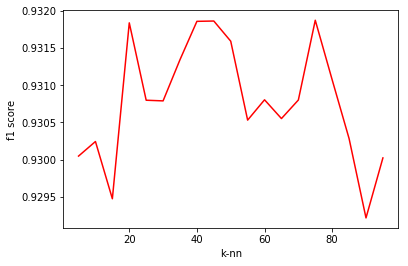

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_range, k_cross_scores, 'r-')
plt.xlabel('k-nn')
plt.ylabel('f1 score')
plt.show()



Experiment with different pairs of genres, and see which 2 genres are most easily differentiable by your classifier.
> rap vs jazz